In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/kaggle/input/birdclef-2025/train.csv')
taxonomy = pd.read_csv('/kaggle/input/birdclef-2025/taxonomy.csv')
train.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [4]:
input_file = "/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg"
output_dir = "/kaggle/working/separated"
os.makedirs(output_dir, exist_ok=True)

##!pip install demucs

In [9]:
import subprocess
import shutil

# Run Demucs on the input file
command = f"demucs --out {output_dir} {input_file}"
subprocess.run(command, shell=True, check=True)

# Locate the extracted "other.wav" file
demucs_output = os.path.join(output_dir, "htdemucs", "CSA36385", "other.wav")
cleaned_output = "/kaggle/working/CSA36385_no_vocals.wav"

# Move the background audio file to the working directory
shutil.move(demucs_output, cleaned_output)

shutil.rmtree(output_dir)  

print(f"Cleaned audio saved at: {cleaned_output}")

Cleaned audio saved at: /kaggle/working/CSA36385_no_vocals.wav


In [10]:
### enhance sonidos de mabiente

from pydub import AudioSegment, effects

# Cargar el audio separado
audio = AudioSegment.from_wav("/kaggle/working/CSA36385_no_vocals.wav")

# Aplicar normalización para elevar el volumen general
normalized_audio = effects.normalize(audio)

# Opcional: Aplicar un filtro para subir agudos (donde suelen estar los sonidos de aves, por ejemplo)
from pydub.effects import high_pass_filter
filtered_audio = high_pass_filter(normalized_audio, cutoff=2000)  # resalta frecuencias por encima de 2kHz

# Exportar el audio mejorado
output_path = f"{output_dir}_ambiente_mejorado.wav"
filtered_audio.export(output_path, format="wav")

print(f"Audio mejorado guardado en: {output_path}")


Audio mejorado guardado en: /kaggle/working/separated_ambiente_mejorado.wav


In [12]:
!pip install webrtcvad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp310-cp310-linux_x86_64.whl size=73470 sha256=e2f8045359bda63289e00fe7605e498b6d27d327ba5f3b2caf9f7f157c80f770
  Stored in directory: /root/.cache/pip/wheels/2a/2b/84/ac7bacfe8c68a87c1ee3dd3c66818a54c71599abf308e8eb35
Successfully built webrtcvad


#### try to cut the audio without voices

works great for the most part, there are still remaining voices in the audio, but with harshr parameters, the animal sound was lost with the voice

In [13]:
import webrtcvad
import wave
import contextlib
from pydub import AudioSegment
import os


ogg_path = "/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg"
converted_path = "/kaggle/working/CSA36385_original.wav"

# Convertir y guardar
audio = AudioSegment.from_ogg(ogg_path)
audio = audio.set_channels(1).set_frame_rate(16000)
audio.export(converted_path, format="wav")


# Ruta del archivo original separado por Demucs sin voces
input_audio_path = converted_path

# Convertimos a mono, 16kHz, 16-bit PCM
audio = AudioSegment.from_wav(input_audio_path)
audio = audio.set_channels(1).set_frame_rate(16000)
temp_wav_path = "/kaggle/working/temp_vad_input.wav"
audio.export(temp_wav_path, format="wav", parameters=["-acodec", "pcm_s16le"])


# Parámetros de VAD
frame_duration = 10  # ms (válidos: 10, 20, 30)
vad = webrtcvad.Vad(3) # param set to 3 --> to keep the animal audio

# Calcular tamaño correcto del frame
with contextlib.closing(wave.open(temp_wav_path, 'rb')) as wf:
    sample_rate = wf.getframerate()
    bytes_per_sample = wf.getsampwidth()
    num_channels = wf.getnchannels()
    assert sample_rate in (8000, 16000, 32000, 48000)
    assert bytes_per_sample == 2
    assert num_channels == 1

    frame_length = int(sample_rate * frame_duration / 1000)  # en frames
    non_speech_segments = []

    offset = 0
    while True:
        frame = wf.readframes(frame_length)
        if len(frame) < frame_length * bytes_per_sample:
            break  # fin del archivo
        is_speech = vad.is_speech(frame, sample_rate)
        if not is_speech:
            start_ms = offset * frame_duration
            end_ms = start_ms + frame_duration
            non_speech_segments.append((start_ms, end_ms))
        offset += 1

# Volver a cargar con pydub
original = AudioSegment.from_wav(temp_wav_path)
ambiente = AudioSegment.empty()
for start, end in non_speech_segments:
    ambiente += original[start:end]

# 🔊 Normalizar y amplificar ###### opcional #######
ambiente = effects.normalize(ambiente)
ambiente += 5  # opcional: boost final ###### variable #######

# Guardar resultado
output_path = "/kaggle/working/solo_ambiente.wav"
ambiente.export(output_path, format="wav")
os.remove(temp_wav_path)

print(f"✅ Audio sin partes habladas guardado como: {output_path}")


✅ Audio sin partes habladas guardado como: /kaggle/working/solo_ambiente.wav


graficar el audio

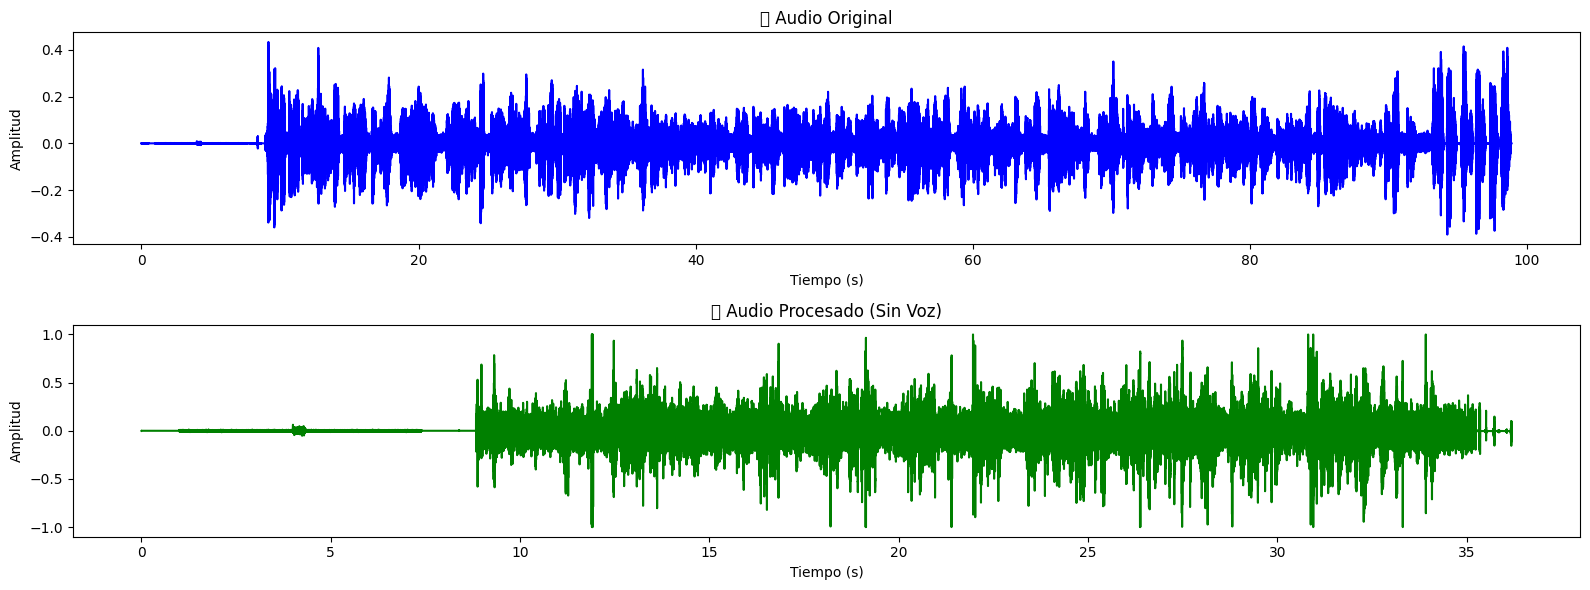

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

def audio_to_np(audio: AudioSegment):
    samples = np.array(audio.get_array_of_samples())
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
        samples = samples.mean(axis=1)  # convert to mono for plotting
    return samples / np.iinfo(samples.dtype).max  # normalize to -1..1

# Cargar audios
original_path = "/kaggle/working/CSA36385_original.wav"
procesado_path = "/kaggle/working/solo_ambiente.wav"

audio_original = AudioSegment.from_wav(original_path)
audio_procesado = AudioSegment.from_wav(procesado_path)

# Convertir a arrays
samples_original = audio_to_np(audio_original)
samples_procesado = audio_to_np(audio_procesado)

# Crear ejes de tiempo
t_original = np.linspace(0, len(audio_original) / 1000, num=len(samples_original))
t_procesado = np.linspace(0, len(audio_procesado) / 1000, num=len(samples_procesado))

# Graficar
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.plot(t_original, samples_original, color='blue')
plt.title("🔊 Audio Original")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.subplot(2, 1, 2)
plt.plot(t_procesado, samples_procesado, color='green')
plt.title("🧼 Audio Procesado (Sin Voz)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

## idea
poner un umbral en el eje y de maxima separacion del centro de la grafica (como se separan las voces, asi nos quedamos solo con el ambiente)

In [15]:
from pydub import AudioSegment
import numpy as np

def detectar_baja_amplitud(audio_path, threshold=0.1, chunk_ms=30):
    audio = AudioSegment.from_wav(audio_path)
    samples = np.array(audio.get_array_of_samples())
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
        samples = samples.mean(axis=1)  # convertir a mono

    max_amp = np.iinfo(samples.dtype).max
    samples = samples / max_amp  # normalizar a -1..1

    chunk_size = int(audio.frame_rate * (chunk_ms / 1000))
    segmentos = []
    for i in range(0, len(samples), chunk_size):
        chunk = samples[i:i + chunk_size]
        if np.max(np.abs(chunk)) < threshold:
            start = (i / audio.frame_rate) * 1000  # en ms
            end = ((i + chunk_size) / audio.frame_rate) * 1000
            segmentos.append((start, end))
    return segmentos

def extraer_fragmentos(audio_path, segmentos, output_path):
    audio = AudioSegment.from_wav(audio_path)
    combinado = AudioSegment.empty()
    for start, end in segmentos:
        frag = audio[start:end]
        combinado += frag
    combinado.export(output_path, format="wav")
    print(f"✅ Guardado: {output_path}")


## FUNCIONA

In [16]:
audio_path = "/kaggle/working/CSA36385_original.wav"
output_path = "/kaggle/working/CSA36385_ambiente_por_amplitud.wav"

segmentos = detectar_baja_amplitud(audio_path, threshold=0.01)
extraer_fragmentos(audio_path, segmentos, output_path)


✅ Guardado: /kaggle/working/CSA36385_ambiente_por_amplitud.wav


In [17]:
#prueba con otro audio al azar

ogg_path = "/kaggle/input/birdclef-2025/train_audio/1194042/CSA18783.ogg"
converted_path = "/kaggle/working/CSA18783_original.wav"

# Convertir y guardar
audio = AudioSegment.from_ogg(ogg_path)
audio = audio.set_channels(1).set_frame_rate(16000)
audio.export(converted_path, format="wav")

<_io.BufferedRandom name='/kaggle/working/CSA18783_original.wav'>

In [18]:
audio_path = "/kaggle/working/CSA18783_original.wav"
output_path = "/kaggle/working/CSA18783_ambiente_por_amplitud.wav"

segmentos = detectar_baja_amplitud(audio_path, threshold=0.2)
extraer_fragmentos(audio_path, segmentos, output_path)


✅ Guardado: /kaggle/working/CSA18783_ambiente_por_amplitud.wav


### Mel-spectrograma

Cada línea horizontal es una frecuencia.
Un chorro de color fuerte indica energía en esa frecuencia.
Si hay un chirrido de pájaro o animal, va a aparecer como una franja breve y marcada (a menudo en frecuencias altas).

In [25]:
# !pip install librosa matplotlib

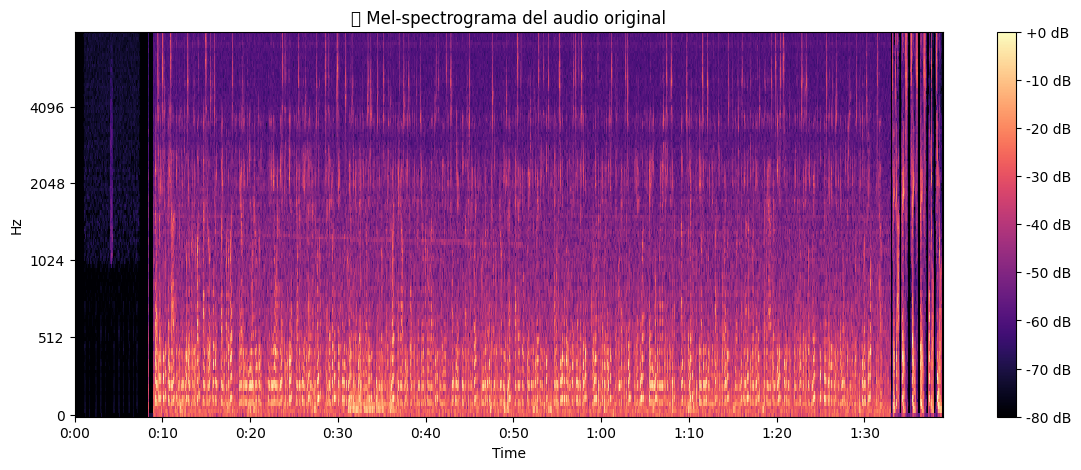

In [40]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Cargar el audio original
audio_path = "/kaggle/working/CSA36385_original.wav"
y, sr = librosa.load(audio_path, sr=16000)  # 'y' = señal, 'sr' = sample rate

# Calcular el mel-spectrograma
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=128)

# Convertir a decibeles (más interpretable visualmente)
S_dB = librosa.power_to_db(S, ref=np.max)

# Visualizar
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("🎼 Mel-spectrograma del audio original")
plt.show()


In [41]:
### tratar de quedarme con la frecuencia de animales nada mas

In [19]:
import librosa
import numpy as np
from pydub import AudioSegment

def detectar_segmentos_agudos(audio_path, sr=16000, min_db=-40, freq_min_bin=50):
    y, sr = librosa.load(audio_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Detectar energía en frecuencias altas
    high_energy = S_dB[freq_min_bin:, :] > min_db
    frame_mask = np.any(high_energy, axis=0)

    # Convertir a tiempo
    hop_duration = 256 / sr
    tiempos = librosa.frames_to_time(np.where(frame_mask)[0], sr=sr, hop_length=256)

    # Agrupar tiempos continuos
    segmentos = []
    if len(tiempos) > 0:
        start = tiempos[0]
        for i in range(1, len(tiempos)):
            if tiempos[i] - tiempos[i - 1] > hop_duration * 2:
                end = tiempos[i - 1]
                segmentos.append((start, end))
                start = tiempos[i]
        segmentos.append((start, tiempos[-1]))
    return segmentos

def extraer_y_unir_segmentos(audio_path, segmentos, output_path):
    audio = AudioSegment.from_wav(audio_path)
    combinado = AudioSegment.empty()
    for start, end in segmentos:
        frag = audio[start * 1000:end * 1000]  # convertir a milisegundos
        combinado += frag
    combinado.export(output_path, format="wav")
    print(f"✅ Audio final exportado con sonidos agudos: {output_path}")
    return combinado

# 📌 Ruta del audio original (puede ser el original o el sin voz)
audio_file = "/kaggle/working/CSA36385_original.wav"
output_file = "/kaggle/working/CSA36385_sonidos_animales.wav"

# 🧠 Detectar los segmentos
segmentos_detectados = detectar_segmentos_agudos(audio_file)

# ✂️ Unir y exportar
audio_final = extraer_y_unir_segmentos(audio_file, segmentos_detectados, output_file)


✅ Audio final exportado con sonidos agudos: /kaggle/working/CSA36385_sonidos_animales.wav


### Estrategia de limpieza de audio

1. Deteccion vos humana --> si hay una voz --> flujo de limpieza 
2. Limpieza de voces humanas--> demucs
2. Detectar baja amplitud y acortar solo un fragmento--> problema es que agrega pedazos intermedios

In [32]:
from pydub import AudioSegment
import numpy as np

def detectar_segmentos_de_sonido(audio_path, threshold=0.1, chunk_ms=30):
    audio = AudioSegment.from_wav(audio_path)
    samples = np.array(audio.get_array_of_samples())
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
        samples = samples.mean(axis=1)

    max_amp = np.iinfo(samples.dtype).max
    samples = samples / max_amp

    frame_rate = audio.frame_rate
    chunk_size = int(frame_rate * (chunk_ms / 1000))
    sonido = []

    for i in range(0, len(samples), chunk_size):
        chunk = samples[i:i + chunk_size]
        rms = np.sqrt(np.mean(chunk**2))  # mejor que max
        start = (i / frame_rate) * 1000
        end = ((i + chunk_size) / frame_rate) * 1000
        if rms >= threshold:
            sonido.append((start, end))
    
    # Combinar segmentos que están muy cerca (menos de 200 ms de separación)
    segmentos_unidos = []
    if sonido:
        prev_start, prev_end = sonido[0]
        for start, end in sonido[1:]:
            if start - prev_end < 2:
                prev_end = end
            else:
                segmentos_unidos.append((prev_start, prev_end))
                prev_start, prev_end = start, end
        segmentos_unidos.append((prev_start, prev_end))
    return segmentos_unidos

def extraer_segmento_mas_largo(audio_path, segmentos, output_path):
    if not segmentos:
        print("⚠️ No se encontraron segmentos de sonido.")
        return
    segmento_mas_largo = max(segmentos, key=lambda x: x[1] - x[0])
    audio = AudioSegment.from_wav(audio_path)
    fragmento = audio[segmento_mas_largo[0]:segmento_mas_largo[1]]
    fragmento.export(output_path, format="wav")
    print(f"✅ Segmento más largo guardado en: {output_path}")


In [36]:
audio_path = "/kaggle/working/CSA36385_original.wav"
output_path = "/kaggle/working/CSA36385_ambiente_por_amplitud_v2.wav"

# Paso 1: Detectar segmentos con sonido (excluye silencios)
segmentos = detectar_segmentos_de_sonido(audio_path, threshold=0.2)

# Paso 2: Extraer el fragmento más largo de sonido detectado
extraer_segmento_mas_largo(audio_path, segmentos, output_path)

✅ Segmento más largo guardado en: /kaggle/working/CSA36385_ambiente_por_amplitud_v2.wav


In [29]:
#prueba con otro audio al azar

ogg_path = "/kaggle/input/birdclef-2025/train_audio/1194042/CSA18783.ogg"
converted_path = "/kaggle/working/CSA18783_original.wav"

# Convertir y guardar
audio = AudioSegment.from_ogg(ogg_path)
audio = audio.set_channels(1).set_frame_rate(16000)
audio.export(converted_path, format="wav")

<_io.BufferedRandom name='/kaggle/working/CSA18783_original.wav'>

In [35]:
audio_path = "/kaggle/working/CSA18783_original.wav"
output_path = "/kaggle/working/CSA18783_ambiente_por_amplitud_v5.wav"

# Paso 1: Detectar segmentos con sonido (excluye silencios)
segmentos = detectar_segmentos_de_sonido(audio_path, threshold=0.2)

# Paso 2: Extraer el fragmento más largo de sonido detectado
extraer_segmento_mas_largo(audio_path, segmentos, output_path)


✅ Segmento más largo guardado en: /kaggle/working/CSA18783_ambiente_por_amplitud_v5.wav


In [ ]:
### Nueva version de extraccion de voz 

In [37]:
from pydub import AudioSegment
import numpy as np

def detectar_sonido_corto(audio_path, threshold=0.02, chunk_ms=20, min_silencio_ms=200):
    audio = AudioSegment.from_wav(audio_path)
    samples = np.array(audio.get_array_of_samples())
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
        samples = samples.mean(axis=1)

    max_amp = np.iinfo(samples.dtype).max
    samples = samples / max_amp
    frame_rate = audio.frame_rate
    chunk_size = int(frame_rate * (chunk_ms / 1000))

    sonido = []
    for i in range(0, len(samples), chunk_size):
        chunk = samples[i:i + chunk_size]
        rms = np.sqrt(np.mean(chunk**2))
        start = (i / frame_rate) * 1000
        end = ((i + chunk_size) / frame_rate) * 1000
        if rms >= threshold:
            sonido.append((start, end))

    # Unir segmentos muy próximos (<100 ms)
    unidos = []
    if sonido:
        prev_start, prev_end = sonido[0]
        for start, end in sonido[1:]:
            if start - prev_end < 100:
                prev_end = end
            else:
                unidos.append((prev_start, prev_end))
                prev_start, prev_end = start, end
        unidos.append((prev_start, prev_end))

    # Filtrar por segmentos rodeados de silencio
    segmento_insecto = []
    for i, (start, end) in enumerate(unidos):
        silencio_antes = start if i == 0 else start - unidos[i-1][1]
        silencio_despues = (unidos[i+1][0] - end) if i+1 < len(unidos) else (audio.duration_seconds * 1000 - end)
        if silencio_antes >= min_silencio_ms and silencio_despues >= min_silencio_ms:
            segmento_insecto.append((start, end))

    return segmento_insecto

def extraer_primer_segmento(audio_path, segmentos, output_path):
    if not segmentos:
        print("⚠️ No se encontraron sonidos aislados.")
        return
    audio = AudioSegment.from_wav(audio_path)
    start, end = segmentos[0]
    fragmento = audio[start:end]
    fragmento.export(output_path, format="wav")
    print(f"✅ Fragmento guardado en: {output_path}")


In [39]:
audio_path = "/kaggle/working/CSA18783_original.wav"
output_path = "/kaggle/working/CSA18783_ambiente_por_amplitud_2.wav"

# Paso 1: Detectar segmentos con sonido (excluye silencios)
segmentos = detectar_sonido_corto(audio_path, threshold=0.2)

# Paso 2: Extraer el fragmento más largo de sonido detectado
extraer_primer_segmento(audio_path, segmentos, output_path)

✅ Fragmento guardado en: /kaggle/working/CSA18783_ambiente_por_amplitud_2.wav


In [40]:
audio_path = "/kaggle/working/CSA36385_original.wav"
output_path = "/kaggle/working/CSA36385_ambiente_por_amplitud_2.wav"

segmentos = detectar_sonido_corto(audio_path, threshold=0.2)

# Paso 2: Extraer el fragmento más largo de sonido detectado
extraer_primer_segmento(audio_path, segmentos, output_path)

✅ Fragmento guardado en: /kaggle/working/CSA36385_ambiente_por_amplitud_2.wav


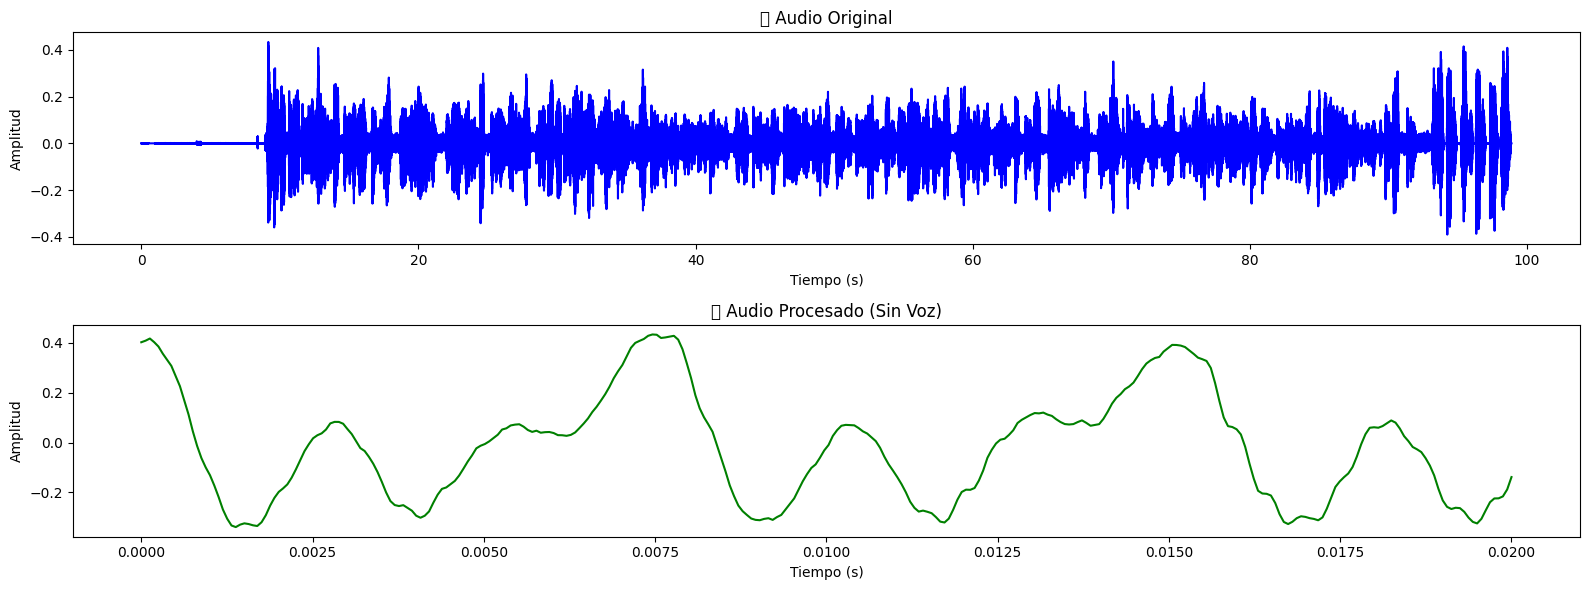

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

def audio_to_np(audio: AudioSegment):
    samples = np.array(audio.get_array_of_samples())
    if audio.channels == 2:
        samples = samples.reshape((-1, 2))
        samples = samples.mean(axis=1)  # convert to mono for plotting
    return samples / np.iinfo(samples.dtype).max  # normalize to -1..1

# Cargar audios
original_path = "/kaggle/working/CSA36385_original.wav"
procesado_path = "/kaggle/working/CSA36385_ambiente_por_amplitud_2.wav"

audio_original = AudioSegment.from_wav(original_path)
audio_procesado = AudioSegment.from_wav(procesado_path)

# Convertir a arrays
samples_original = audio_to_np(audio_original)
samples_procesado = audio_to_np(audio_procesado)

# Crear ejes de tiempo
t_original = np.linspace(0, len(audio_original) / 1000, num=len(samples_original))
t_procesado = np.linspace(0, len(audio_procesado) / 1000, num=len(samples_procesado))

# Graficar
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.plot(t_original, samples_original, color='blue')
plt.title("🔊 Audio Original")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.subplot(2, 1, 2)
plt.plot(t_procesado, samples_procesado, color='green')
plt.title("🧼 Audio Procesado (Sin Voz)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

### Nueva correcion para detectar el bulto al inicio en mas de un caso

In [42]:
from pydub import AudioSegment
import numpy as np

def detectar_bulto_inicio(audio_path, max_duracion_ms=5000, umbral_rms=0.005, chunk_ms=10):
    audio = AudioSegment.from_wav(audio_path)
    inicio = audio[:max_duracion_ms]

    samples = np.array(inicio.get_array_of_samples())
    if inicio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)

    samples = samples / np.max(np.abs(samples))  # normalizar
    frame_rate = inicio.frame_rate
    chunk_size = int(frame_rate * (chunk_ms / 1000))

    for i in range(0, len(samples) - chunk_size, chunk_size):
        chunk = samples[i:i + chunk_size]
        rms = np.sqrt(np.mean(chunk**2))
        if rms > umbral_rms:
            start_ms = (i / frame_rate) * 1000
            end_ms = ((i + chunk_size) / frame_rate) * 1000
            return (start_ms, end_ms)

    return None

def extraer_bulto(audio_path, segmento, output_path):
    if segmento is None:
        print("⚠️ No se detectó ningún bulto con suficiente energía.")
        return
    audio = AudioSegment.from_wav(audio_path)
    start, end = segmento
    fragmento = audio[start:end]
    fragmento.export(output_path, format="wav")
    print(f"✅ Bulto del insecto exportado a: {output_path}")


In [43]:
audio_path = "/kaggle/working/CSA36385_original.wav"
output_path = "/kaggle/working/CSA36385_ambiente_por_amplitud_3.wav"

segmento = detectar_bulto_inicio(audio_path, max_duracion_ms=5000, umbral_rms=0.005)
extraer_bulto(audio_path, segmento, output_path)

✅ Bulto del insecto exportado a: /kaggle/working/CSA36385_ambiente_por_amplitud_3.wav
